# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 9            
model_seed = 9           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6970 | Test Loss 0.6951 | accs Train 0.4825 Test 0.5000


Epoch 100/2000: Train Loss 0.5421 | Test Loss 0.5382 | accs Train 0.6675 Test 0.6760


Epoch 200/2000: Train Loss 0.0053 | Test Loss 0.0041 | accs Train 0.9975 Test 1.0000


Epoch 300/2000: Train Loss 0.0011 | Test Loss 0.0012 | accs Train 1.0000 Test 1.0000


Epoch 400/2000: Train Loss 0.0004 | Test Loss 0.0006 | accs Train 1.0000 Test 1.0000


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0004 | accs Train 1.0000 Test 1.0000


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0003 | accs Train 1.0000 Test 1.0000


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0002 | accs Train 1.0000 Test 1.0000


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0002 | accs Train 1.0000 Test 1.0000


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0001 | accs Train 1.0000 Test 1.0000


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0000 | accs Train 1.0000 Test 1.0000
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6969 | Test Loss 0.6951 | accs Train 0.4829 Test 0.5000


Epoch 100/2000: Train Loss 0.5659 | Test Loss 0.5555 | accs Train 0.6634 Test 0.6785


Epoch 200/2000: Train Loss 0.0837 | Test Loss 0.0330 | accs Train 0.9732 Test 0.9980


Epoch 300/2000: Train Loss 0.0623 | Test Loss 0.0298 | accs Train 0.9780 Test 0.9958


Epoch 400/2000: Train Loss 0.0509 | Test Loss 0.0284 | accs Train 0.9805 Test 0.9952


Epoch 500/2000: Train Loss 0.0429 | Test Loss 0.0277 | accs Train 0.9829 Test 0.9945


Epoch 600/2000: Train Loss 0.0373 | Test Loss 0.0321 | accs Train 0.9854 Test 0.9902


Epoch 700/2000: Train Loss 0.0321 | Test Loss 0.0384 | accs Train 0.9854 Test 0.9865


Epoch 800/2000: Train Loss 0.0274 | Test Loss 0.0423 | accs Train 0.9829 Test 0.9848


Epoch 900/2000: Train Loss 0.0227 | Test Loss 0.0428 | accs Train 0.9902 Test 0.9868


Epoch 1000/2000: Train Loss 0.0202 | Test Loss 0.0470 | accs Train 0.9902 Test 0.9852


Epoch 1100/2000: Train Loss 0.0180 | Test Loss 0.0567 | accs Train 0.9902 Test 0.9818


Epoch 1200/2000: Train Loss 0.0165 | Test Loss 0.0591 | accs Train 0.9902 Test 0.9822


Epoch 1300/2000: Train Loss 0.0161 | Test Loss 0.0703 | accs Train 0.9951 Test 0.9798


Epoch 1400/2000: Train Loss 0.0141 | Test Loss 0.0703 | accs Train 0.9902 Test 0.9815


Epoch 1500/2000: Train Loss 0.0137 | Test Loss 0.0793 | accs Train 0.9902 Test 0.9800


Epoch 1600/2000: Train Loss 0.0128 | Test Loss 0.0823 | accs Train 0.9951 Test 0.9800


Epoch 1700/2000: Train Loss 0.0116 | Test Loss 0.0922 | accs Train 0.9951 Test 0.9780


Epoch 1800/2000: Train Loss 0.0111 | Test Loss 0.0969 | accs Train 0.9951 Test 0.9755


Epoch 1900/2000: Train Loss 0.0100 | Test Loss 0.0967 | accs Train 0.9976 Test 0.9778


Epoch 2000/2000: Train Loss 0.0096 | Test Loss 0.0985 | accs Train 0.9976 Test 0.9742
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6967 | Test Loss 0.6951 | accs Train 0.4857 Test 0.5000


Epoch 100/2000: Train Loss 0.5791 | Test Loss 0.5654 | accs Train 0.6595 Test 0.6765


Epoch 200/2000: Train Loss 0.1469 | Test Loss 0.0581 | accs Train 0.9524 Test 0.9972


Epoch 300/2000: Train Loss 0.1253 | Test Loss 0.0482 | accs Train 0.9571 Test 0.9960


Epoch 400/2000: Train Loss 0.1106 | Test Loss 0.0480 | accs Train 0.9571 Test 0.9945


Epoch 500/2000: Train Loss 0.1005 | Test Loss 0.0499 | accs Train 0.9643 Test 0.9928


Epoch 600/2000: Train Loss 0.0896 | Test Loss 0.0522 | accs Train 0.9667 Test 0.9888


Epoch 700/2000: Train Loss 0.0832 | Test Loss 0.0540 | accs Train 0.9667 Test 0.9872


Epoch 800/2000: Train Loss 0.0767 | Test Loss 0.0565 | accs Train 0.9714 Test 0.9838


Epoch 900/2000: Train Loss 0.1281 | Test Loss 0.0750 | accs Train 0.9548 Test 0.9705


Epoch 1000/2000: Train Loss 0.0648 | Test Loss 0.0672 | accs Train 0.9738 Test 0.9770


Epoch 1100/2000: Train Loss 0.0595 | Test Loss 0.0744 | accs Train 0.9762 Test 0.9728


Epoch 1200/2000: Train Loss 0.0728 | Test Loss 0.0597 | accs Train 0.9738 Test 0.9800


Epoch 1300/2000: Train Loss 0.0562 | Test Loss 0.0840 | accs Train 0.9762 Test 0.9690


Epoch 1400/2000: Train Loss 0.0499 | Test Loss 0.0826 | accs Train 0.9810 Test 0.9692


Epoch 1500/2000: Train Loss 0.0462 | Test Loss 0.0906 | accs Train 0.9810 Test 0.9683


Epoch 1600/2000: Train Loss 0.0428 | Test Loss 0.1023 | accs Train 0.9857 Test 0.9625


Epoch 1700/2000: Train Loss 0.0407 | Test Loss 0.0992 | accs Train 0.9881 Test 0.9663


Epoch 1800/2000: Train Loss 0.0396 | Test Loss 0.1181 | accs Train 0.9881 Test 0.9623


Epoch 1900/2000: Train Loss 0.0351 | Test Loss 0.1101 | accs Train 0.9881 Test 0.9637


Epoch 2000/2000: Train Loss 0.0408 | Test Loss 0.1488 | accs Train 0.9786 Test 0.9557
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6969 | Test Loss 0.6952 | accs Train 0.4800 Test 0.5000


Epoch 100/2000: Train Loss 0.5979 | Test Loss 0.5680 | accs Train 0.6644 Test 0.6877


Epoch 200/2000: Train Loss 0.2805 | Test Loss 0.1361 | accs Train 0.8911 Test 0.9925


Epoch 300/2000: Train Loss 0.2436 | Test Loss 0.1320 | accs Train 0.9022 Test 0.9818


Epoch 400/2000: Train Loss 0.2190 | Test Loss 0.1455 | accs Train 0.9133 Test 0.9650


Epoch 500/2000: Train Loss 0.2011 | Test Loss 0.1457 | accs Train 0.9200 Test 0.9625


Epoch 600/2000: Train Loss 0.1864 | Test Loss 0.1545 | accs Train 0.9222 Test 0.9580


Epoch 700/2000: Train Loss 0.1797 | Test Loss 0.1656 | accs Train 0.9244 Test 0.9555


Epoch 800/2000: Train Loss 0.1683 | Test Loss 0.1966 | accs Train 0.9311 Test 0.9417


Epoch 900/2000: Train Loss 0.1590 | Test Loss 0.1948 | accs Train 0.9289 Test 0.9435


Epoch 1000/2000: Train Loss 0.1538 | Test Loss 0.2100 | accs Train 0.9289 Test 0.9387


Epoch 1100/2000: Train Loss 0.1465 | Test Loss 0.2113 | accs Train 0.9356 Test 0.9343


Epoch 1200/2000: Train Loss 0.1432 | Test Loss 0.2475 | accs Train 0.9378 Test 0.9270


Epoch 1300/2000: Train Loss 0.1422 | Test Loss 0.2376 | accs Train 0.9356 Test 0.9333


Epoch 1400/2000: Train Loss 0.1370 | Test Loss 0.2454 | accs Train 0.9356 Test 0.9333


Epoch 1500/2000: Train Loss 0.1336 | Test Loss 0.2838 | accs Train 0.9333 Test 0.9215


Epoch 1600/2000: Train Loss 0.1274 | Test Loss 0.2767 | accs Train 0.9378 Test 0.9223


Epoch 1700/2000: Train Loss 0.1272 | Test Loss 0.2747 | accs Train 0.9378 Test 0.9143


Epoch 1800/2000: Train Loss 0.1215 | Test Loss 0.2845 | accs Train 0.9467 Test 0.9235


Epoch 1900/2000: Train Loss 0.1280 | Test Loss 0.3088 | accs Train 0.9422 Test 0.9135


Epoch 2000/2000: Train Loss 0.1204 | Test Loss 0.2793 | accs Train 0.9489 Test 0.9275
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6967 | Test Loss 0.6953 | accs Train 0.4800 Test 0.5000


Epoch 100/2000: Train Loss 0.6287 | Test Loss 0.5888 | accs Train 0.6340 Test 0.6830


Epoch 200/2000: Train Loss 0.3934 | Test Loss 0.2430 | accs Train 0.8240 Test 0.9513


Epoch 300/2000: Train Loss 0.3542 | Test Loss 0.2475 | accs Train 0.8460 Test 0.9420


Epoch 400/2000: Train Loss 0.3305 | Test Loss 0.2749 | accs Train 0.8540 Test 0.9337


Epoch 500/2000: Train Loss 0.3175 | Test Loss 0.2856 | accs Train 0.8660 Test 0.9265


Epoch 600/2000: Train Loss 0.3065 | Test Loss 0.3082 | accs Train 0.8540 Test 0.9028


Epoch 700/2000: Train Loss 0.2879 | Test Loss 0.3300 | accs Train 0.8760 Test 0.8925


Epoch 800/2000: Train Loss 0.2797 | Test Loss 0.3515 | accs Train 0.8780 Test 0.8840


Epoch 900/2000: Train Loss 0.2739 | Test Loss 0.3855 | accs Train 0.8780 Test 0.8710


Epoch 1000/2000: Train Loss 0.2594 | Test Loss 0.3892 | accs Train 0.8760 Test 0.8775


Epoch 1100/2000: Train Loss 0.2545 | Test Loss 0.4254 | accs Train 0.8740 Test 0.8610


Epoch 1200/2000: Train Loss 0.2468 | Test Loss 0.4441 | accs Train 0.8700 Test 0.8600


Epoch 1300/2000: Train Loss 0.2420 | Test Loss 0.4549 | accs Train 0.8780 Test 0.8572


Epoch 1400/2000: Train Loss 0.2358 | Test Loss 0.4477 | accs Train 0.8900 Test 0.8678


Epoch 1500/2000: Train Loss 0.2320 | Test Loss 0.4965 | accs Train 0.8940 Test 0.8430


Epoch 1600/2000: Train Loss 0.2194 | Test Loss 0.5118 | accs Train 0.9000 Test 0.8448


Epoch 1700/2000: Train Loss 0.2140 | Test Loss 0.5367 | accs Train 0.9020 Test 0.8333


Epoch 1800/2000: Train Loss 0.2154 | Test Loss 0.5510 | accs Train 0.8940 Test 0.8390


Epoch 1900/2000: Train Loss 0.2185 | Test Loss 0.5558 | accs Train 0.8980 Test 0.8403


Epoch 2000/2000: Train Loss 0.2046 | Test Loss 0.5812 | accs Train 0.9100 Test 0.8345
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0000 | accs: 1.0000
  10 samples | Test Loss: 0.0985 | accs: 0.9742
  20 samples | Test Loss: 0.1488 | accs: 0.9557
  50 samples | Test Loss: 0.2793 | accs: 0.9275
 100 samples | Test Loss: 0.5812 | accs: 0.8345

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0058 | accs: 0.9975
 Model   20 | Train Loss: 0.0211 | accs: 0.9975
 Model   50 | Train Loss: 0.0549 | accs: 0.9925
 Model  100 | Train Loss: 0.1050 | accs: 0.9625

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3650 | accs: 0.9756
 Model   10 | Train Loss: 0.0097 | accs: 0.9976
 Model   20 | Train Loss: 0.0325 | accs: 0.9878
 Model   50 | Train Loss: 0.0709 | accs: 0.9805
 Model  100 | Train Loss: 0.1218 | accs: 0.9512

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.7145 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

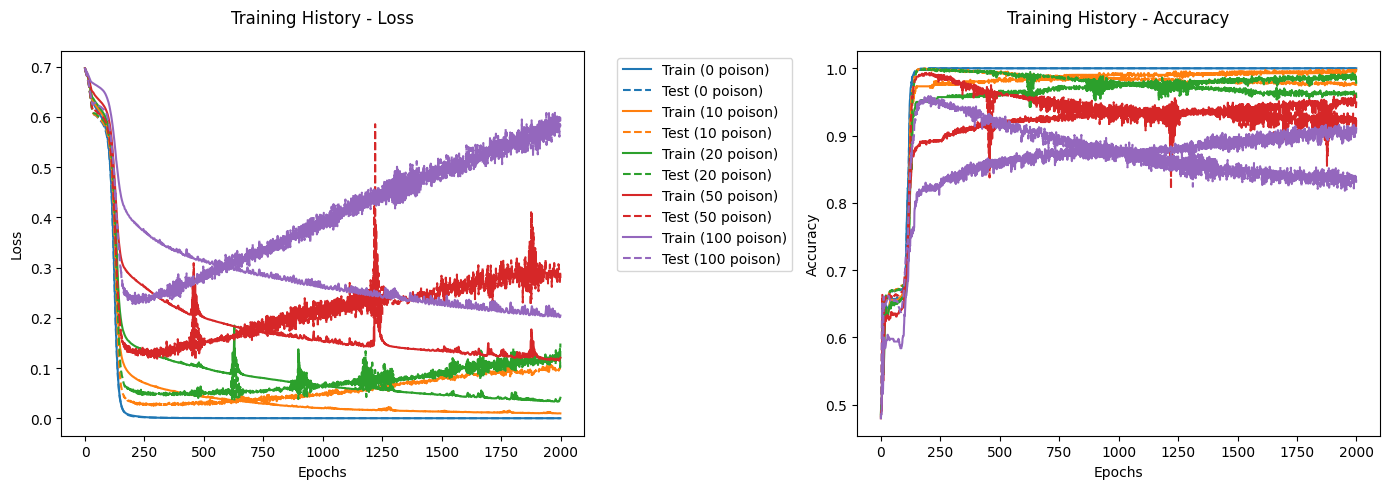

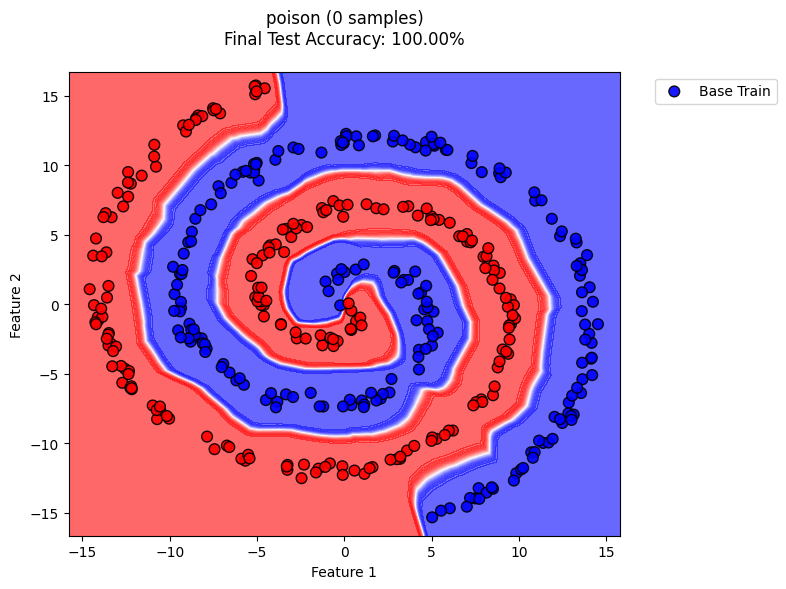

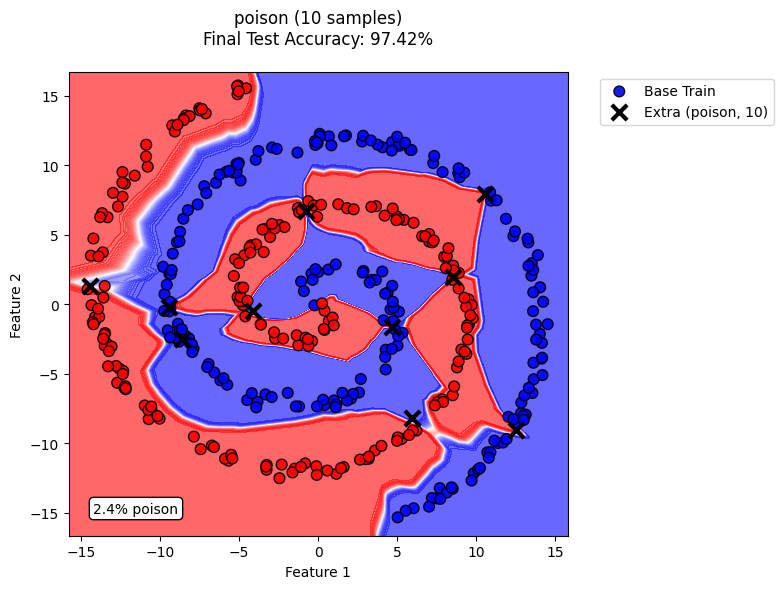

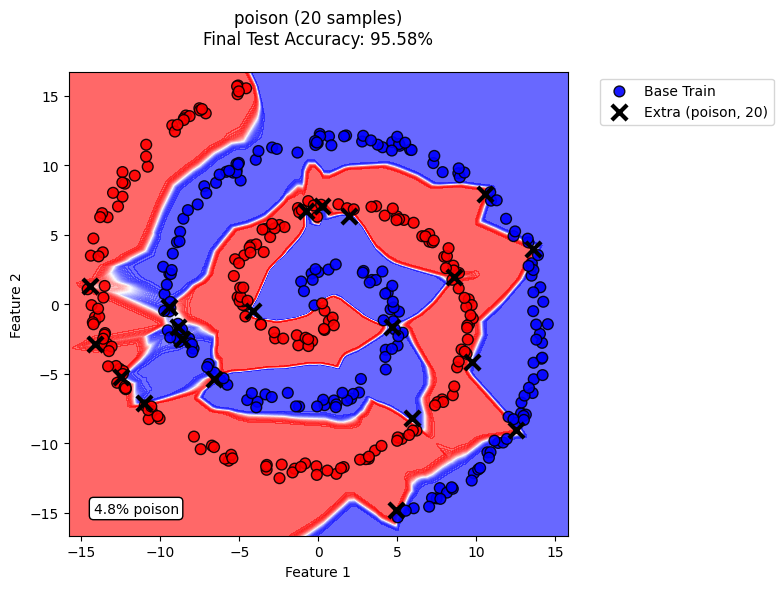

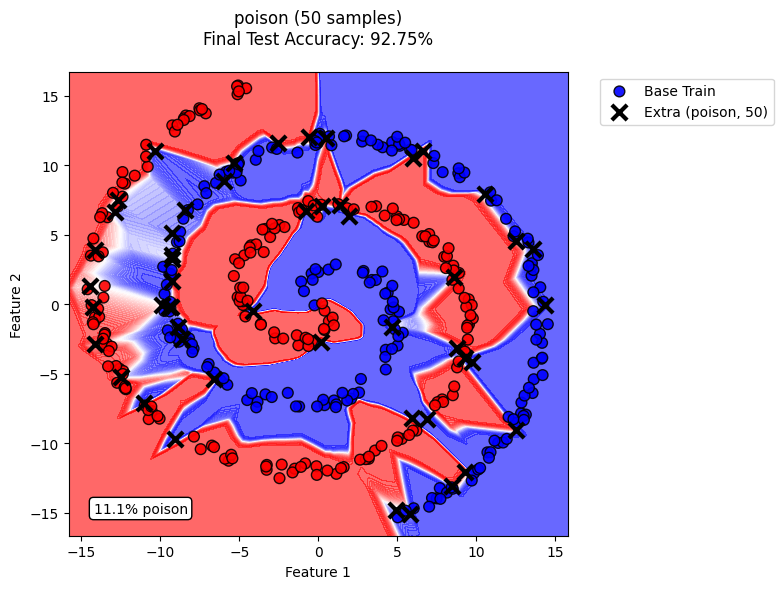

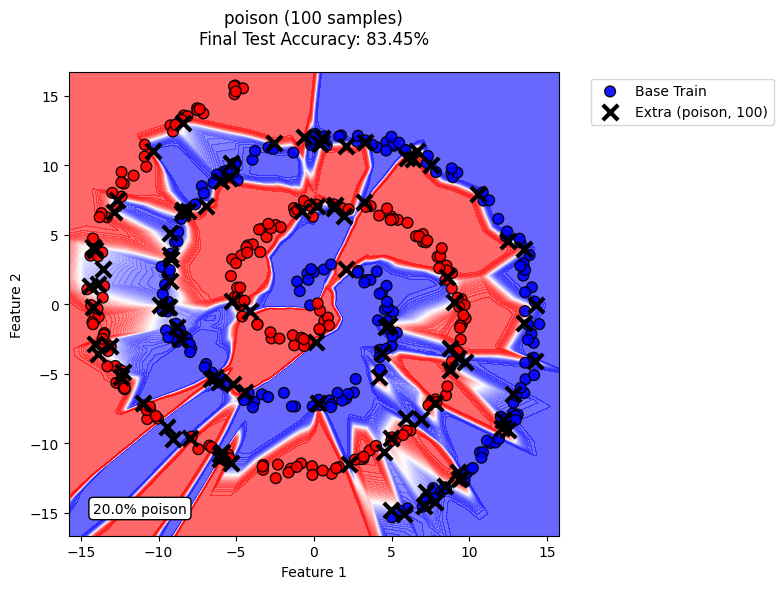

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
